In [92]:
import os
import re
import numpy as np
os.chdir('/home/gerald/Documents/These/SystemX/fork/EM_Hyperbolic/')
from launcher_tools import logger
print(os.getcwd())

/home/gerald/Documents/These/SystemX/fork/EM_Hyperbolic


In [120]:
import torch
def get_values(regex):
    size = [2,3,4,5,10]
    size_inv = {2:0,3:1,4:2,5:3,10:4}
    MEANS = [0,0,0,0,0]
    VAR =[0,0,0,0,0]
    RES = [[],[],[],[],[]]
    STD_KM = [[],[],[],[],[]]
    directory_list = list()
    for root, dirs, files in os.walk("RESULTS", topdown=False):
        for name in dirs:
            if re.search(regex, name) is not None:
                directory_list.append(os.path.join(root, name))
    
    STD_KM_MAX = [[],[],[],[],[]]
    for i in directory_list:
        print(i)
        log = logger.JSONLogger(i+"/log.json", mod="continue")
        RES[size_inv[log["size"]]] = log["kmeans_from_embeddings"]["RES"]
        STD_KM[size_inv[log["size"]]] = torch.Tensor(log["kmeans_from_embeddings"]["STD_KMEANS"]).sum(-1).tolist()
        STD_KM_MAX[size_inv[log["size"]]] = torch.Tensor(log["kmeans_from_embeddings"]["STD_KMEANS"]).max(-1)[0].tolist()
    
    res = torch.Tensor(RES)
    std_km = torch.Tensor(STD_KM)
    std_km_max = torch.Tensor(STD_KM_MAX)
    print(res.size())
    print(res[torch.arange(5),std_km.min(-1)[1]])
    best_res_var = res[torch.arange(5),std_km.min(-1)[1]]
    best_res_var_max = res[torch.arange(5),std_km_max.min(-1)[1]]
    return res.mean(-1).tolist(), res.std(-1).tolist() ,size, std_km.tolist() , best_res_var.tolist(), best_res_var_max.tolist()

In [121]:
MEANS_A, VAR_A, SIZE_A, STD_KM_A , BEST_A, BESTM_A= get_values("BOOKS-\d*D-KMEANS.*")
MEANS_B, VAR_B, SIZE_B, STD_KM_B , BEST_B, BESTM_B= get_values(".*BOOKS-euclidean.*-KMEANS.*")

RESULTS/BOOKS-4D-KMEANS-1
RESULTS/BOOKS-2D-KMEANS-1
RESULTS/BOOKS-5D-KMEANS-2
RESULTS/BOOKS-2D-KMEANS-2
RESULTS/BOOKS-5D-KMEANS-1
RESULTS/BOOKS-3D-KMEANS-2
RESULTS/BOOKS-3D-KMEANS-1
RESULTS/BOOKS-10D-KMEANS-2
RESULTS/BOOKS-10D-KMEANS-1
RESULTS/BOOKS-4D-KMEANS-2
torch.Size([5, 40])
tensor([74.2857, 79.0476, 76.1905, 76.1905, 80.0000])
RESULTS/BOOKS-euclidean-5D-KMEANS-2
RESULTS/BOOKS-euclidean-10D-KMEANS-1
RESULTS/BOOKS-euclidean-2D-KMEANS-2
RESULTS/BOOKS-euclidean-3D-KMEANS-2
RESULTS/BOOKS-euclidean-3D-KMEANS-1
RESULTS/BOOKS-euclidean-5D-KMEANS-1
RESULTS/BOOKS-euclidean-2D-KMEANS-1
RESULTS/BOOKS-euclidean-4D-KMEANS-2
RESULTS/BOOKS-euclidean-10D-KMEANS-2
RESULTS/BOOKS-euclidean-4D-KMEANS-1
torch.Size([5, 40])
tensor([79.0476, 79.0476, 78.0952, 78.0952, 79.0476])


<IPython.core.display.Javascript object>


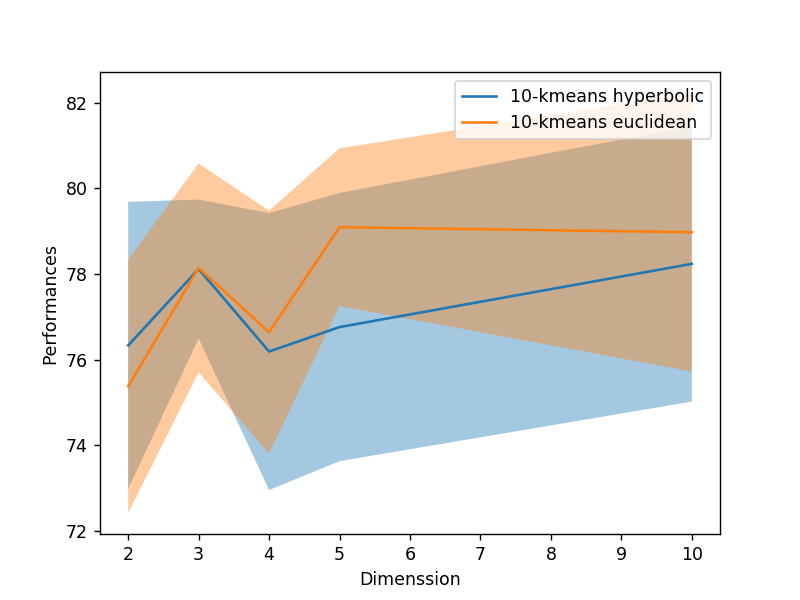

In [122]:
from matplotlib import pyplot as plt
%matplotlib nbagg
import numpy as np
size = SIZE_A
var = np.array(VAR_A)
mean = np.array(MEANS_A)
plt.plot(size, MEANS_A, label="10-kmeans hyperbolic")
plt.ylabel("Performances")
plt.xlabel("Dimenssion")
plt.fill_between(size, mean-var, mean+var, alpha=0.4)

var = np.array(VAR_B)
mean = np.array(MEANS_B)
plt.plot(size, MEANS_B, label="10-kmeans euclidean")
plt.fill_between(size, mean-var, mean+var, alpha=0.4)
plt.legend()


In [123]:
def table_latex(sizes, means, var, best, best_m, eu_means, eu_var, best_eu, best_eu_m):
    mstr="\\begin{table} \n \t \centering \n \t \\begin{tabular}{|c|ccc|ccc|}\n"
    mstr+= "\t\t\hline Dimension & H-Mean & H-A & H-B &  E-Mean & E-A & E-B \\\\ \hline\n"
    
    for size, mean, std, mv, best_m, e_mean, e_std, e_mv, e_best_m in zip(sizes, means, var, best, best_m, eu_means, eu_var, best_eu, best_eu_m):
        mean, std, mv, e_mean, e_std, e_mv = mean*10//1/10, std*10//1/10, mv*10//1/10, e_mean*10//1/10, e_std*10//1/10, e_mv *10//1/10
        best_m, e_best_m = best_m*10//1/10, e_best_m*10//1/10

        mstr+="\t\t"+str(size)+"& $"+str(mean)+" \pm "+str(std)+"$ & $"+str(mv)+"$ & $"+str(best_m)+"$& $"+str(e_mean)+" \pm "+str(e_std)+"$&$"+str(e_mv)+"$ & $"+str(e_best_m)+"$\\\\ \hline\n"
    mstr+="\t\end{tabular}\n \end{table}"
    return mstr
    

In [124]:
print(table_latex(size, MEANS_A, VAR_A, BEST_A, BESTM_A, MEANS_B,  VAR_B, BEST_B, BESTM_B))

\begin{table} 
 	 \centering 
 	 \begin{tabular}{|c|ccc|ccc|}
		\hline Dimension & H-Mean & H-A & H-B &  E-Mean & E-A & E-B \\ \hline
		2& $76.3 \pm 3.3$ & $74.2$ & $74.2$& $75.3 \pm 2.9$&$79.0$ & $76.1$\\ \hline
		3& $78.1 \pm 1.6$ & $79.0$ & $78.0$& $78.1 \pm 2.4$&$79.0$ & $77.1$\\ \hline
		4& $76.1 \pm 3.2$ & $76.1$ & $76.1$& $76.6 \pm 2.8$&$78.0$ & $77.1$\\ \hline
		5& $76.7 \pm 3.1$ & $76.1$ & $75.2$& $79.0 \pm 1.8$&$78.0$ & $80.0$\\ \hline
		10& $78.2 \pm 3.2$ & $80.0$ & $78.0$& $78.9 \pm 3.2$&$79.0$ & $78.0$\\ \hline
	\end{tabular}
 \end{table}
